In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import sys, os, importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
repo_paths = ['/home/simonealbanesi/repos/IPAM2021_ML/', '/home/simone/repos/IPAM2021_ML/']
for rp in repo_paths:
    if os.path.isdir(rp):
        repo_path = rp
        break
sys.path.insert(0, repo_path+'utils/')

In [4]:
import fancyplots as fp
import classyNN   as cnn
import errstats   as es
import errsurf

## Input

In [5]:
hlayers_sizes   = (400,400)
seed            = 1
verbose_train   = True
epochs          = 10
batch_size      = 128
SNR_min         = 0 # used only in train-dataset

show_figs       = True
save_figs       = False

# for the LSO, 1.45 corresponds to a=0.99 in Kerr
#out_intervals   = np.array([[1,120], [0.8, 82], [-1, 1], [-1,1], [0.7, 75], [1, 100], [1.45,9], [0.05, 0.5]])

out_intervals = np.array([[1,120], [-1, 1], [-1,1], [0.85, 80]])

linear_output  = False # if True, out_intervals is ignored.
compact_scaler = False
std_scaler     = True
sigma0         = 10

learning_rate  = 0.001;

show_err_distr = False

# Warning 1: using out_interval=None is not equivalnt to linear_output=True!!
# Warning 2: using linear_output=True can produce unphysical prediction!

m1_cutoff = None
Mc_min    = None

data_path = repo_path+'datasets/GstLAL/'

## Start by loading the data. This should be exported in py-module

In [6]:
fname_train_data = data_path+'train_NS.csv'
fname_test_data  = data_path+'test_NS.csv'
train_datasets   = cnn.extract_data(fname_train_data, skip_header=True)
test_datasets    = cnn.extract_data(fname_test_data, skip_header=True)

train_datasets  = shuffle(train_datasets)

In [7]:
# ID                0
# m1_inj            1
# m2_inj            2
# chi1_inj          3
# chi2_inj          4
# mc_inj            5
# q_inj             6
# R_isco_inj        7
# Compactness_inj   8
# m1_rec            9
# m2_rec           10
# chi1_rec         11
# chi2_rec         12
# mc_rec           13
# frac_mc_err      14
# q_rec            15
# R_isco_rec       16
# Compactness_rec  17
# snr              18
# s                19

def load_GstLAL_data(X, features='mass&spin', m1_cutoff=None, Mc_min=None):
    """ Maybe a little bit pedantic, 
    but I prefer to keep this function as
    readable as possible 
    """
    if features=='all':
        m1_inj          = X[:, 1]
        m2_inj          = X[:, 2]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        q_inj           = X[:, 6]
        R_isco_inj      = X[:, 7]
        Compactness_inj = X[:, 8]
        m1_rec          = X[:, 9]
        m2_rec          = X[:,10]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        q_rec           = X[:,15]
        R_isco_rec      = X[:,16]
        Compactness_rec = X[:,17]
        inj = np.column_stack((m1_inj,m2_inj,chi1_inj,chi2_inj,mc_inj,q_inj,R_isco_inj,Compactness_inj))
        rec = np.column_stack((m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec,Compactness_rec))
        names = [r'$m_1$', r'$m_2$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$', r'$q$', \
                 r'$R_{\rm isco}$', r'$C$']
        
    elif features=='no_compactness':
        m1_inj          = X[:, 1]
        m2_inj          = X[:, 2]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        q_inj           = X[:, 6]
        R_isco_inj      = X[:, 7]
        m1_rec          = X[:, 9]
        m2_rec          = X[:,10]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        q_rec           = X[:,15]
        R_isco_rec      = X[:,16]
        inj = np.column_stack((m1_inj,m2_inj,chi1_inj,chi2_inj,mc_inj,q_inj,R_isco_inj))
        rec = np.column_stack((m1_rec,m2_rec,chi1_rec,chi2_rec,mc_rec,q_rec,R_isco_rec))
        names = [r'$m_1$', r'$m_2$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$', r'$q$', \
                 r'$R_{\rm isco}$']
        
    elif features=='mass&spin':
        m1_inj          = X[:, 1]
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        mc_inj          = X[:, 5]
        m1_rec          = X[:, 9]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        mc_rec          = X[:,13]
        inj = np.column_stack((m1_inj,chi1_inj,chi2_inj,mc_inj))
        rec = np.column_stack((m1_rec,chi1_rec,chi2_rec,mc_rec))
        names = [r'$m_1$', r'$\chi_1$', r'$\chi_2$', r'${\cal M}_c$']
        
    elif features=='spin':
        chi1_inj        = X[:, 3]
        chi2_inj        = X[:, 4]
        chi1_rec        = X[:,11]
        chi2_rec        = X[:,12]
        inj = np.column_stack((chi1_inj,chi2_inj))
        rec = np.column_stack((chi1_rec,chi2_rec))
        names = [r'$\chi_1$', r'$\chi_2$']
    ID  = X[:,0]
    snr = X[:,18]
    
    if m1_cutoff is not None and features!='spin':
        mask = np.argwhere(m1_inj>m1_cutoff)
        ID  = np.delete(ID , mask)
        snr = np.delete(snr, mask)
        inj = np.delete(inj, mask, axis=0)
        rec = np.delete(rec, mask, axis=0)
    
    if Mc_min is not None and features!='spin':
        mask = np.argwhere(mc_inj<Mc_min)
        ID  = np.delete(ID , mask)
        snr = np.delete(snr, mask)
        inj = np.delete(inj, mask, axis=0)
        rec = np.delete(rec, mask, axis=0)
    
    out          = {}
    out['inj']   = inj
    out['rec']   = rec
    out['SNR']   = snr
    out['names'] = names
    out['ID']    = ID
    return out

--------------------------------------------------
Nsamples (tot): 139999
--------------------------------------------------


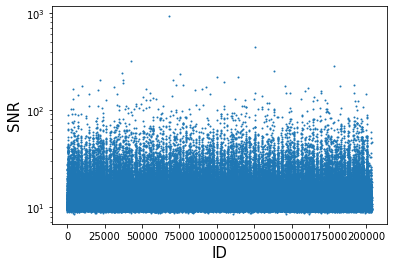

--------------------------------------------------  train  -------------------------------------------------


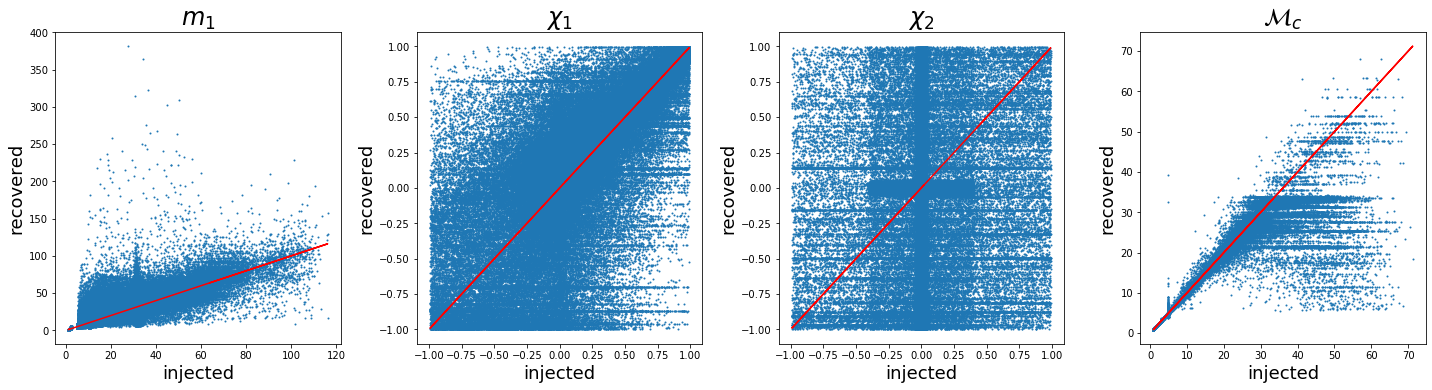

In [8]:
train_data_split = load_GstLAL_data(train_datasets, features='mass&spin', m1_cutoff=m1_cutoff, Mc_min=Mc_min)
train_inj = train_data_split['inj']
train_rec = train_data_split['rec']
train_snr = train_data_split['SNR']
train_ID  = train_data_split['ID']

print('-'*50)
print('Nsamples (tot):', len(train_snr))
print('-'*50)
if SNR_min>min(train_snr):
    rows2remove = []
    for i in range(len(train_snr)):
        snr = train_snr[i]
        if snr<SNR_min:
            rows2remove.append(i)
    train_inj = np.delete(train_inj, rows2remove, axis=0)
    train_rec = np.delete(train_rec, rows2remove, axis=0)
    train_snr = np.delete(train_snr, rows2remove, axis=0)
    train_ID  = np.delete(train_ID,  rows2remove, axis=0)
    print('SNR_min :', SNR_min)
    print('Nsamples:', len(train_snr))
    
test_data_split = load_GstLAL_data(test_datasets, features='mass&spin', m1_cutoff=m1_cutoff, Mc_min=Mc_min)
test_inj = test_data_split['inj']
test_rec = test_data_split['rec']
test_snr = test_data_split['SNR']

names     = train_data_split['names']
nfeatures = len(train_inj[0,:])
ntrain    = len(train_inj[:,0])
ntest     = len( test_inj[:,0])

plt.figure
plt.scatter(train_ID, train_snr, s=1)
plt.yscale('log')
plt.ylabel('SNR', fontsize=15)
plt.xlabel('ID', fontsize=15)
if save_figs:
    plt.savefig('snr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()
    
print('-'*50,' train ','-'*49)
plt.figure(figsize=(20,10))
for i in range(nfeatures):
    ax = plt.subplot(241+i)
    ax.scatter(train_inj[:,i], train_rec[:,i],s=1)
    ax.plot(train_inj[:,i], train_inj[:,i], 'r')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel('injected', fontsize=18)
    ax.set_ylabel('recovered', fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig('rec_vs_inj.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

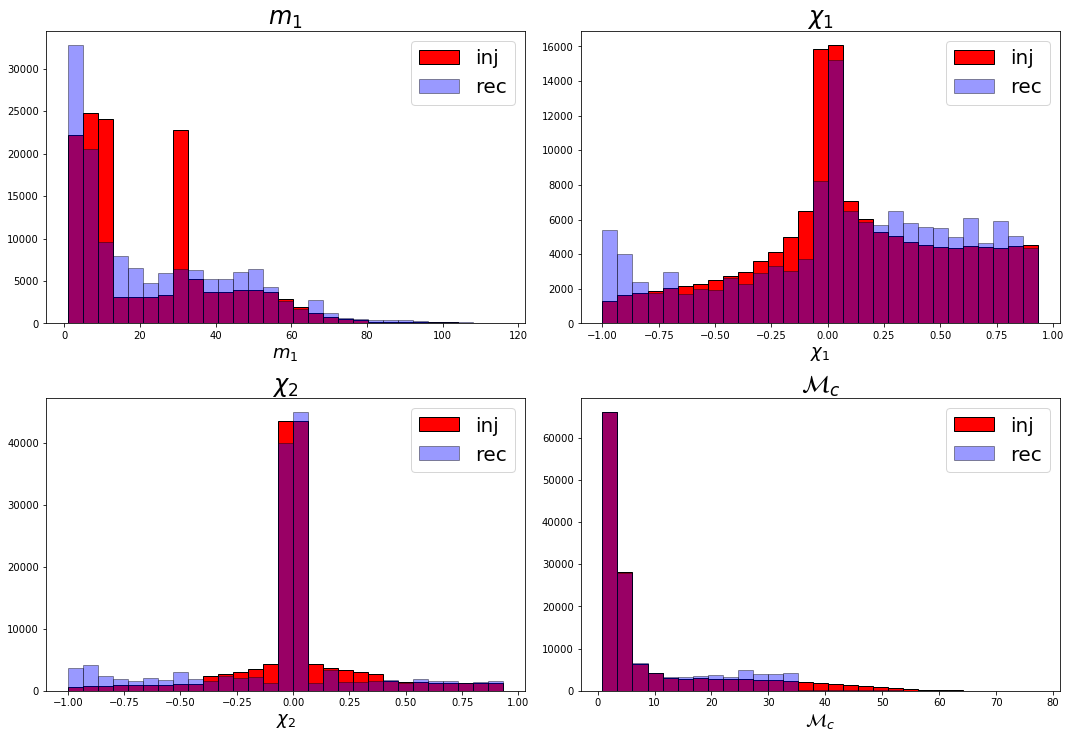

In [9]:
plt.figure(figsize=(15,20))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(4,2,i+1)
    if out_intervals is not None:
        fmin = out_intervals[i][0]
        fmax = out_intervals[i][1]
    else:
        fmin = min(train_inj[:,i])
        fmax = max(train_inj[:,i])
    fstep = (fmax-fmin)/nbins
    ax.hist(train_inj[:,i], bins=np.arange(fmin, fmax, fstep), alpha=1,   color=[1,0,0], label='inj', ec='black')
    ax.hist(train_rec[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.4, color=[0,0,1], label='rec', ec='black')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

In [10]:
NN = cnn.RegressionNN(nfeatures=nfeatures, hlayers_sizes=hlayers_sizes, out_intervals=out_intervals, 
                      seed=seed, linear_output=linear_output)
NN.print_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 400)               2000      
                                                                 
 dense_1 (Dense)             (None, 400)               160400    
                                                                 
 dense_2 (Dense)             (None, 4)                 1604      
                                                                 
Total params: 164,004
Trainable params: 164,004
Non-trainable params: 0
_________________________________________________________________


In [11]:
NN.load_train_dataset(xtrain_data=train_rec, ytrain_data=train_inj, 
                      verbose=False, standard_scaler=std_scaler, sigma0=sigma0, compact_scaler=compact_scaler)

--------------------------------------------------------------------------------
feature n.1
--------------------------------------------------------------------------------


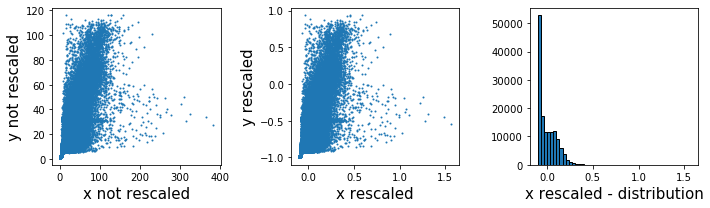

max diff check :  2.842170943040401e-14
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.2
--------------------------------------------------------------------------------


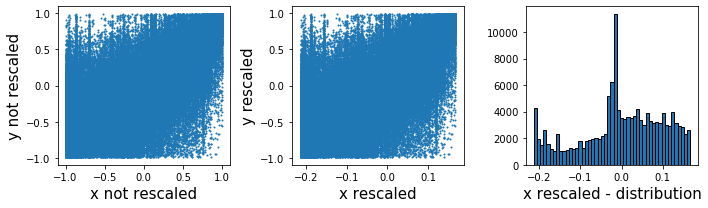

max diff check :  3.3306690738754696e-16
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.3
--------------------------------------------------------------------------------


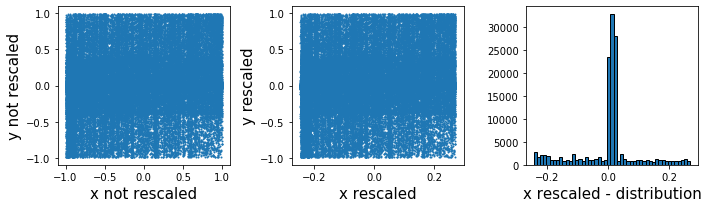

max diff check :  2.220446049250313e-16
NaN found in Y :  0
NaN found in X1:  0 



--------------------------------------------------------------------------------
feature n.4
--------------------------------------------------------------------------------


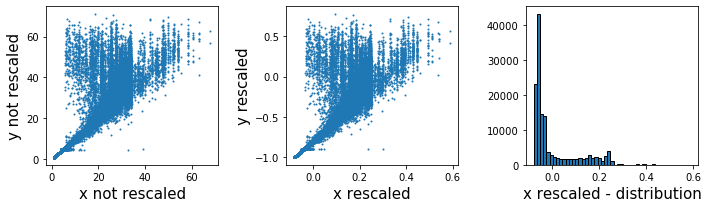

max diff check :  1.4210854715202004e-14
NaN found in Y :  0
NaN found in X1:  0 





In [12]:
X0 = NN.xtrain_notnorm
Y  = NN.scaler_x.transform(X0)
X1 = NN.scaler_x.inverse_transform(Y)

for i in range(NN.nfeatures):
    print('-'*80, 'feature n.'+str(i+1), '-'*80, sep='\n')
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.scatter(NN.xtrain_notnorm[:,i], NN.ytrain_notnorm[:,i], s=1)
    plt.xlabel('x not rescaled', fontsize=15)
    plt.ylabel('y not rescaled', fontsize=15)
    plt.subplot(132)
    plt.scatter(NN.xtrain[:,i], NN.ytrain[:,i], s=1)
    plt.xlabel('x rescaled', fontsize=15)
    plt.ylabel('y rescaled', fontsize=15)
    nan_counter_Y  = 0
    nan_counter_X1 = 0
    for j in range(len(Y[:,i])):
        y  =  Y[j,i]
        x1 = X1[j,i]
        if np.isnan(y):
            nan_counter_Y += 1
        if np.isnan(x1):
            nan_counter_X1 += 1
    if nan_counter_Y == 0:
        plt.subplot(133)
        x = NN.xtrain[:,i]
        plt.hist(x, bins=np.linspace(min(x), max(x), 50), histtype='bar', ec='black')
        #plt.hist(Y[:,i], bins=np.linspace(min(x), max(x), 50), alpha=0.5, histtype='bar', ec='black')
        plt.xlabel('x rescaled - distribution', fontsize=15)
    plt.tight_layout()
    if save_figs:
        plt.savefig('scaler_feature'+str(i)+'.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()
    diff = X1[:,i]-X0[:,i]
    print('max diff check : ', max(diff))
    print('NaN found in Y : ', nan_counter_Y)
    print('NaN found in X1: ', nan_counter_X1, '\n\n\n')

In [13]:
NN.training(epochs=epochs, batch_size=batch_size, verbose=verbose_train, learning_rate=learning_rate)

Epoch 1/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - R2metric: 0.8251
Epoch 2/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - R2metric: 0.8530
Epoch 3/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - R2metric: 0.8623
Epoch 4/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - R2metric: 0.8655
Epoch 5/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - R2metric: 0.8673
Epoch 6/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - R2metric: 0.8683
Epoch 7/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - R2metric: 0.8688
Epoch 8/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0366 

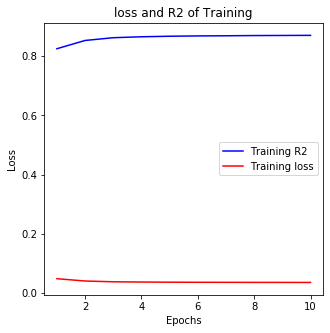

In [14]:
NN.plot_history(show=show_figs, save=save_figs)

In [15]:
NN.load_test_dataset(xtest_data=test_rec, ytest_data=test_inj, verbose=True)

In [16]:
print('-'*25, 'R2 for recovery', '-'*25)
def R2_numpy(y_true, y_pred):
            SS_res = np.sum((y_true - y_pred )**2)
            SS_tot = np.sum((y_true - np.mean(y_true))**2)
            return 1-SS_res/SS_tot
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_rec[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))

print('-'*25, 'R2 for prediction', '-'*23)
NN.print_metrics()

"""
print('-'*25, 'R2 for prediction, check', '-'*23)
test_pred = NN.compute_prediction(NN.xtest, transform_output=True)
for i in range(nfeatures):
    R2 = R2_numpy(test_inj[:,i], test_pred[:,i])  
    print('R2[{:2d}]         : {:.5f}'.format(i,R2))
""";

------------------------- R2 for recovery -------------------------
R2[ 0]         : 0.61870
R2[ 1]         : 0.28814
R2[ 2]         : -1.56280
R2[ 3]         : 0.84706
------------------------- R2 for prediction -----------------------
Final R2 mean  : 0.68139
R2[ 0]         : 0.87955
R2[ 1]         : 0.73524
R2[ 2]         : 0.14459
R2[ 3]         : 0.96620


## Histograms

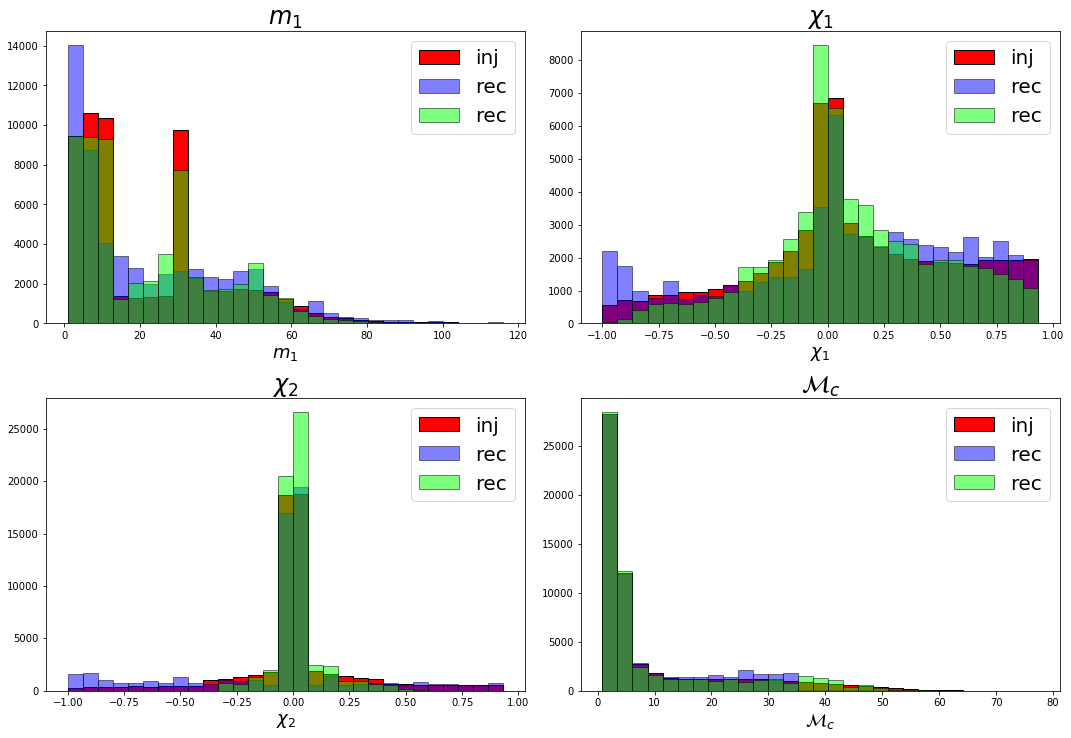

In [17]:
pred = NN.compute_prediction(NN.xtest, transform_output=True) # normalized prediction
plt.figure(figsize=(15,20))
nbins = 30
for i in range(nfeatures):
    ax = plt.subplot(4,2,i+1)
    if out_intervals is not None:
        fmin = out_intervals[i][0]
        fmax = out_intervals[i][1]
    else:
        fmin = min(train_inj[:,i])
        fmax = max(train_inj[:,i])
    fstep = (fmax-fmin)/nbins
    ax.hist(test_inj[:,i], bins=np.arange(fmin, fmax, fstep), alpha=1,   color=[1,0,0], label='inj', ec='black')
    ax.hist(test_rec[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=[0,0,1], label='rec', ec='black')
    ax.hist( pred[:,i], bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=[0,1,0], label='rec', ec='black')
    ax.set_title(names[i], fontsize=24)
    ax.set_xlabel(names[i], fontsize=18)
    ax.legend(fontsize=20)
plt.tight_layout()
if save_figs:
    plt.savefig('distr_wpred.png',dpi=200,bbox_inches='tight')
if show_figs:
    plt.show()
else:
    plt.close()

------------------------------------------------ m1 --------------------------------------------------
mean rec   rel diff  :  -0.17166 (std= 0.58254, | rel diff |= 0.34841)
mean pred  rel diff  :  -0.12735 (std= 0.38691, | rel diff |= 0.21451)


median rec   rel diff  :  -0.08910
median pred  rel diff  :  -0.05109


recovery   below fmin= -4.00: 174
recovery   above fmax=  1.00: 0
prediction below fmin= -4.00: 48
prediction above fmax=  1.00: 0


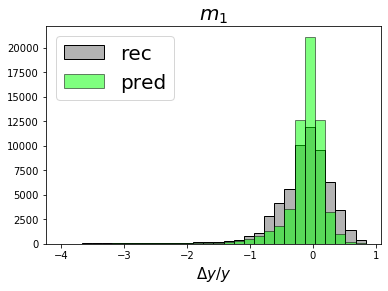

---------------------------------------------  chi1 --------------------------------------------------
mean rec  difference :  -0.00289 (std= 0.38856, |difference|= 0.26675)
mean pred difference :   0.00172 (std= 0.23696, |difference|= 0.14513)


median rec  difference :  -0.02098
median pred difference :   0.02324


recovery   below fmin= -1.70: 5
recovery   above fmax=  1.70: 28
prediction below fmin= -1.70: 0
prediction above fmax=  1.70: 0


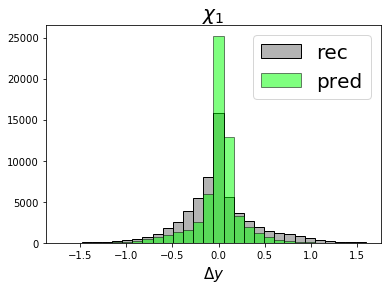

---------------------------------------------- chi2 --------------------------------------------------
mean rec  difference :   0.06589 (std= 0.45543, |difference|= 0.27354)
mean pred difference :   0.00002 (std= 0.26586, |difference|= 0.14982)


median rec  difference :   0.00390
median pred difference :  -0.00259


recovery   below fmin= -1.70: 43
recovery   above fmax=  1.70: 162
prediction below fmin= -1.70: 0
prediction above fmax=  1.70: 0


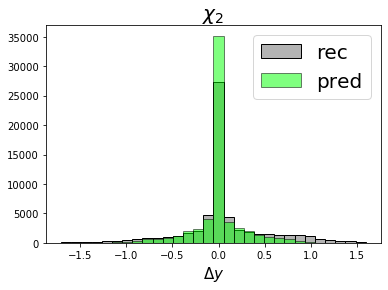

------------------------------------------------ Mc --------------------------------------------------
mean rec   rel diff  :   0.02365 (std= 0.11199, | rel diff |= 0.03979)
mean pred  rel diff  :   0.07356 (std= 0.14438, | rel diff |= 0.11160)


median rec   rel diff  :  -0.00005
median pred  rel diff  :   0.06539


recovery   below fmin= -1.50: 5
recovery   above fmax=  1.00: 0
prediction below fmin= -1.50: 32
prediction above fmax=  1.00: 0


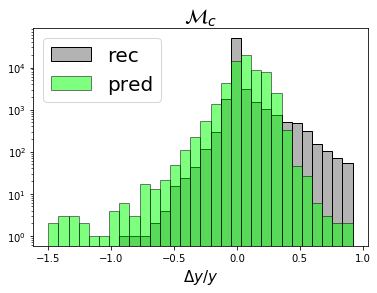

In [18]:
"""
nolatex_names = [ 'm1',   'm2', ' chi1',  'chi2',    'Mc',    'q',  'R_ISCO',     'C']
fmin_vec      = [   -4,     -3,    -1.7,    -1.7,    -1.5,     -4,      -1.7,    -0.5]
fmax_vec      = [    1,      1,     1.7,     1.7,     1.0,    1.2,       0.8,     0.5]
abs_diff_vec  = [False,  False,    True,    True,   False,  False,     False,    True]
logscale_vec  = [False,  False,   False,   False,    True,  False,     False,   False]
"""
nolatex_names = [ 'm1',   ' chi1',  'chi2',    'Mc']
fmin_vec      = [   -4,     -1.7,    -1.7,    -1.5 ]
fmax_vec      = [    1,      1.7,     1.7,     1.0 ]
abs_diff_vec  = [False,     True,    True,   False ]
logscale_vec  = [False,    False,   False,    True ]

for i in range(nfeatures):
    print('-'*(50-len(nolatex_names[i])), nolatex_names[i], '-'*50)
    NN.plot_err_histogram(feature_idx=i, fmin=fmin_vec[i], fmax=fmax_vec[i], verbose=True, 
                          abs_diff=abs_diff_vec[i], name=names[i], show=show_figs, save=save_figs, 
                          logscale=logscale_vec[i])

In [19]:
#test_prediction = NN.compute_prediction(NN.xtest, transform_output=True)
#cnn.write_result('cNN_prediction.csv', test_prediction, verbose=True)

## Other plots 

In [20]:
#import importlib
#importlib.reload(fancyplots)

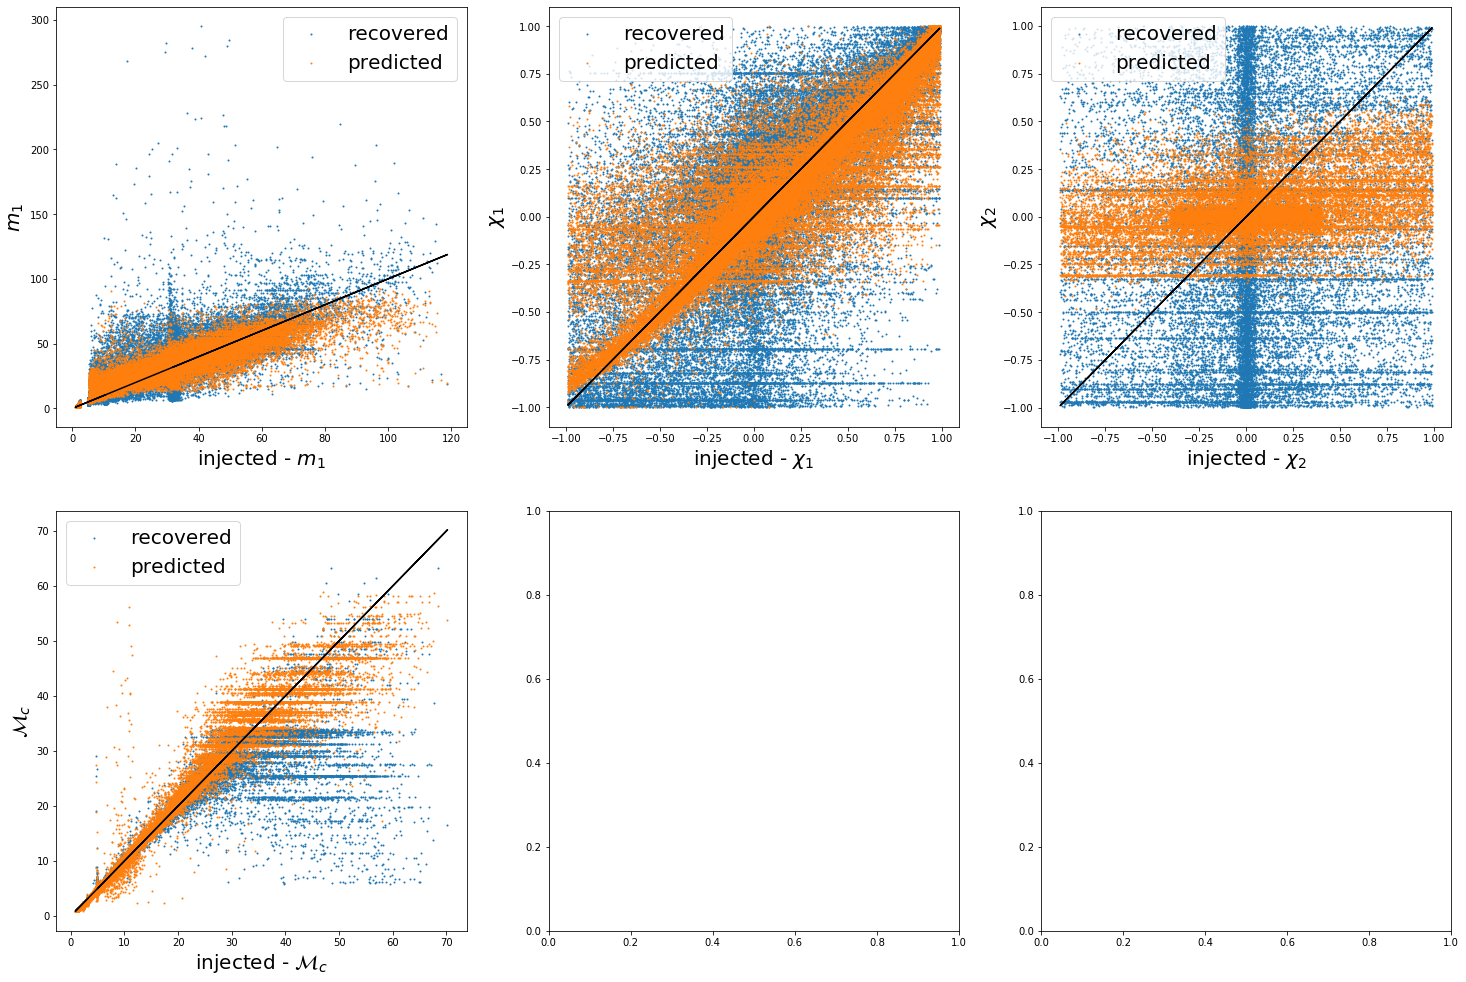

In [21]:
prediction = NN.compute_prediction(NN.xtest) # normalized prediction
fp.checkRegressionPlot(NN.xtest, NN.ytest, prediction, names, 
                              scaler_y=NN.scaler_y, scaler_x=NN.scaler_x, show=show_figs, save=save_figs)

In [22]:
predicted = NN.compute_prediction(NN.xtest, transform_output=True)
injected  = NN.ytest_notnorm
recovered = NN.xtest_notnorm

In [23]:
if nfeatures==8:
    m1_pred = predicted[:,0]
    m2_pred = predicted[:,1]
    Mc_pred = predicted[:,4]

    m1_inj  = injected[:,0]
    m2_inj  = injected[:,1]
    Mc_inj  = injected[:,4]

    m1_rec  = recovered[:,0]
    m2_rec  = recovered[:,1]
    Mc_rec  = recovered[:,4]

    def compute_Mc(m1,m2):
        return (m1*m2)**(3/5)/(m1+m2)**(1/5)

    Mc_comp = compute_Mc(m1_pred, m2_pred)

    color_rec  = np.array([0.6,0.6,0.6])
    color_pred = np.array([0,1,0])
    color_comp = np.array([1,0,0])

    plt.figure
    plt.scatter(Mc_inj, Mc_rec , s=1, c=color_rec.reshape(1,-1))
    plt.scatter(Mc_inj, Mc_pred, s=1, c=color_pred.reshape(1,-1))
    plt.scatter(Mc_inj, Mc_comp, s=1, c=color_comp.reshape(1,-1))
    plt.plot(Mc_inj, Mc_inj, c=[0,0,0])
    plt.xlabel(r'$M_c$ - inj', fontsize=15)
    plt.ylabel(r'$M_c$', fontsize=15)
    if save_figs:
        plt.savefig('Mc.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

    nbins = 31

    errors_rec  = (Mc_inj- Mc_rec )/Mc_inj
    errors_pred = (Mc_inj- Mc_pred)/Mc_inj
    errors_comp = (Mc_inj- Mc_comp)/Mc_inj

    fmin  = -3
    fmax  =  3
    fstep = (fmax-fmin)/nbins

    pred_min_outliers = 0 
    pred_max_outliers = 0 
    for i in range(len(errors_pred)):
        if errors_pred[i]<fmin:
            pred_min_outliers += 1
    for i in range(len(errors_pred)):
        if errors_pred[i]>fmax:
            pred_max_outliers += 1 
    rec_min_outliers = 0 
    rec_max_outliers = 0 
    for i in range(len(errors_rec)):
        if errors_rec[i]<fmin:
            rec_min_outliers += 1
    for i in range(len(errors_rec)):
        if errors_rec[i]>fmax:
            rec_max_outliers += 1 
    comp_min_outliers = 0 
    comp_max_outliers = 0 
    for i in range(len(errors_comp)):
        if errors_comp[i]<fmin:
            comp_min_outliers += 1
    for i in range(len(errors_comp)):
        if errors_comp[i]>fmax:
            comp_max_outliers += 1 

    print('recovery    below fmin={:6.2f}: {:d}'.format(fmin,  rec_min_outliers))
    print('recovery    above fmax={:6.2f}: {:d}'.format(fmax,  rec_max_outliers))
    print('prediction  below fmin={:6.2f}: {:d}'.format(fmin, pred_min_outliers))
    print('prediction  above fmax={:6.2f}: {:d}'.format(fmax, pred_max_outliers))
    print('computation below fmin={:6.2f}: {:d}'.format(fmin, comp_min_outliers))
    print('computation above fmax={:6.2f}: {:d}'.format(fmax, comp_max_outliers))

    plt.figure
    plt.hist(errors_rec , bins=np.arange(fmin, fmax, fstep), alpha=1.0, color=color_rec,  label='rec',
             histtype='bar', ec='black')
    plt.hist(errors_pred, bins=np.arange(fmin, fmax, fstep), alpha=0.7, color=color_pred, label='pred',
             histtype='bar', ec='black')
    plt.hist(errors_comp, bins=np.arange(fmin, fmax, fstep), alpha=0.5, color=color_comp, label='comp',
             histtype='bar', ec='black')
    plt.legend(fontsize=20)
    plt.xlabel(r'$\Delta y/y$', fontsize=15)
    if save_figs:
        plt.savefig('err_hist_Mc.png',dpi=200,bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close()

## Error statistics

In [24]:
# Note that this is on train-dataset! We need the training-prediction to compute the error-statistic (I think)
predicted = NN.compute_prediction(NN.xtrain, transform_output=True)
injected  = NN.ytrain_notnorm
recovered = NN.xtrain_notnorm

In [25]:
importlib.reload(es)

<module 'errstats' from '/home/simone/repos/IPAM2021_ML/algo/classy_NN/errstats.py'>

In [26]:
n = 1000
if show_err_distr: 
    idx = 3
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_Mc = es.ErrorStats()
    ErrorStats_Mc.fit(predicted[:,idx],injected[:,idx], n=n, project=True, sigma=5, npoly=[5,5,2])
    ErrorStats_Mc.plot_bins()
    #ErrorStats_Mc.plot_xstep()
    ErrorStats_Mc.plot_moments(plot_poly_fit=True)
    ErrorStats_Mc.plot_stats(plot_xbins=False, show_info=False)
    """
    idx = 2
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_chi2 = es.ErrorStats()
    ErrorStats_chi2.fit(predicted[:,idx],injected[:,idx], n=n, project=False, sigma=5, npoly=[3,4,1])
    ErrorStats_chi2.plot_bins()
    #ErrorStats_chi2.plot_xstep()
    ErrorStats_chi2.plot_moments(plot_poly_fit=True)
    ErrorStats_chi2.plot_stats(plot_xbins=False, show_info=False)
    
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_chi2 = es.ErrorStats()
    ErrorStats_chi2.fit(predicted[:,idx],injected[:,idx], n=n, project=True, sigma=5, npoly=[3,4,1])
    ErrorStats_chi2.plot_bins()
    ErrorStats_chi2.plot_moments(plot_poly_fit=True)
    ErrorStats_chi2.plot_stats(plot_xbins=False, show_info=False)
    
    idx = 0
    print('\n', '#'*80,'\n', 'feature n.', idx+1, ': ', names[idx].replace('$', ''), '\n', '#'*80, sep='')
    ErrorStats_m1 = es.ErrorStats()
    ErrorStats_m1.fit(predicted[:,idx],injected[:,idx], n=n, project=False, sigma=5, npoly=[3,2,1])
    ErrorStats_m1.plot_bins()
    ErrorStats_chi2.plot_moments(plot_poly_fit=True)
    ErrorStats_m1.plot_stats(plot_xbins=False, show_info=False)
    """;

## New method to estimate errors

In [27]:
importlib.reload(errsurf)

X = predicted[:,0]
Y =  injected[:,0]

esurf_m1 = errsurf.ErrorSurface(X, Y, Nx=50, Ny=50, exp_step=True, dx_expstep=1.05, dy_expstep=1.05,
                            method='cubic', Nx_grid=1000, Ny_grid=1000)

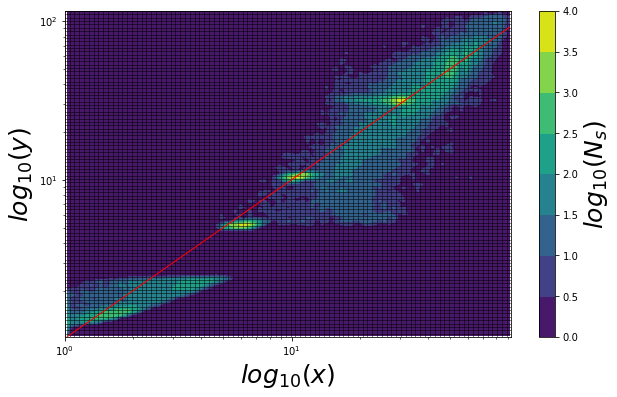

In [28]:
esurf_m1.plot_surf(log_scale=True)

####################################################################################################
x0: 2
####################################################################################################


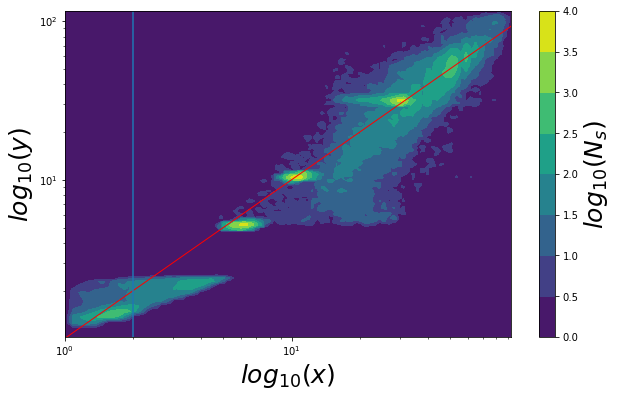

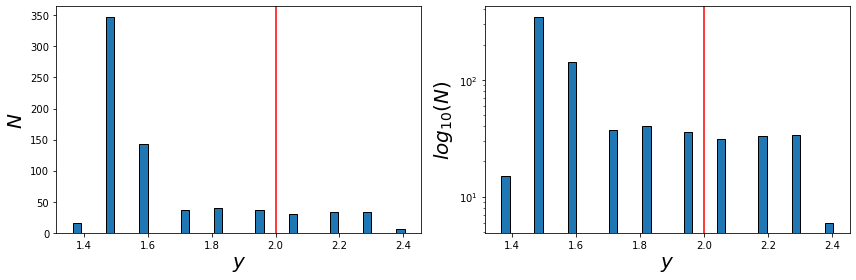

####################################################################################################
x0: 8
####################################################################################################


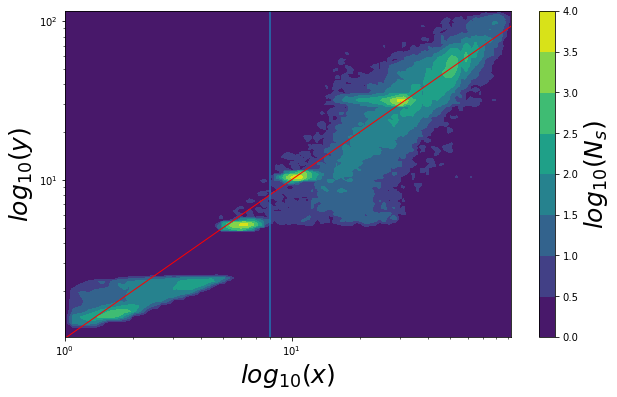

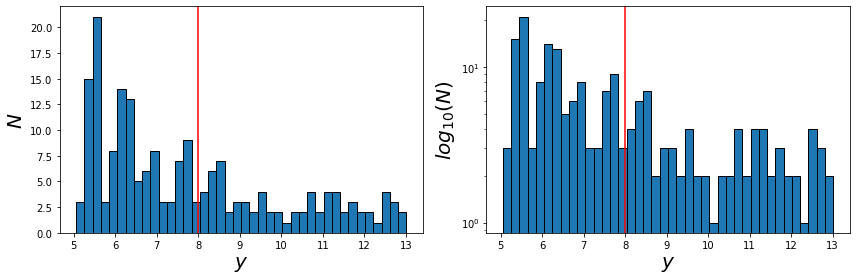

####################################################################################################
x0: 10
####################################################################################################


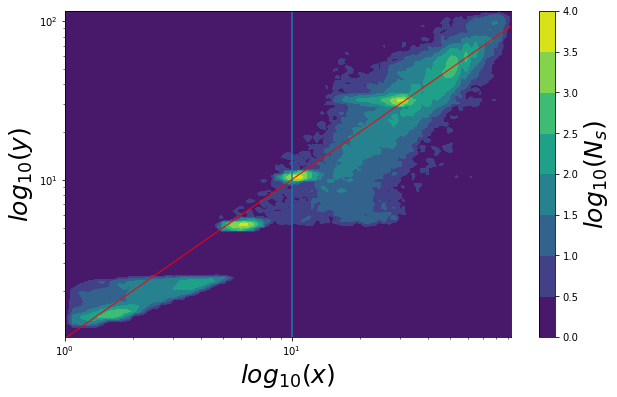

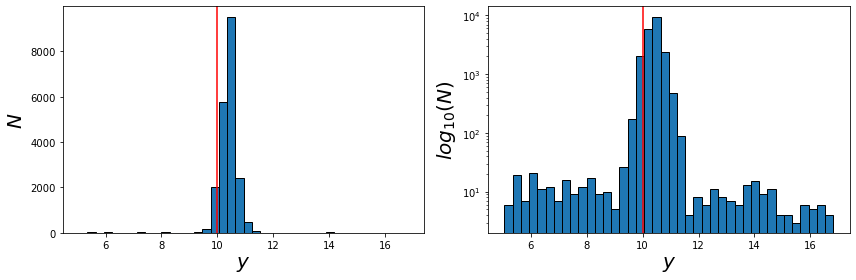

####################################################################################################
x0: 31.5
####################################################################################################


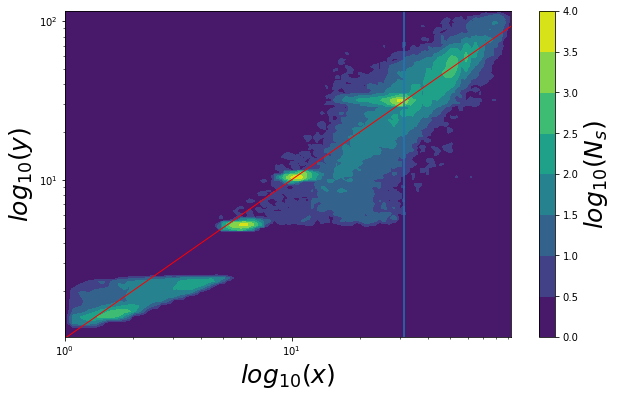

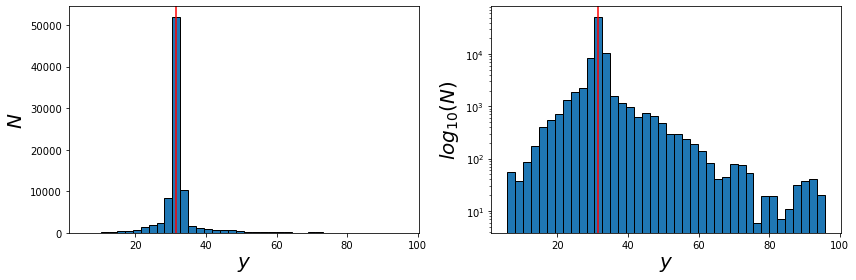

####################################################################################################
x0: 80
####################################################################################################


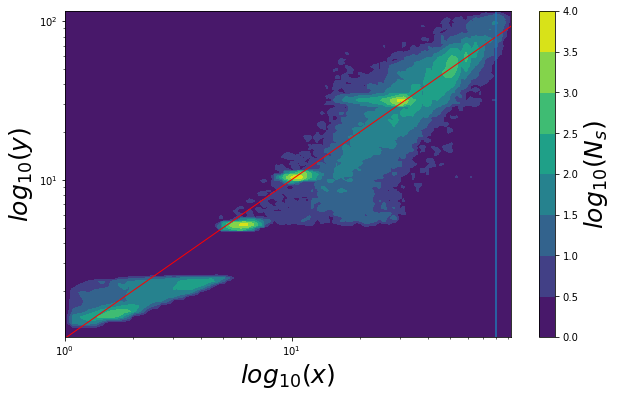

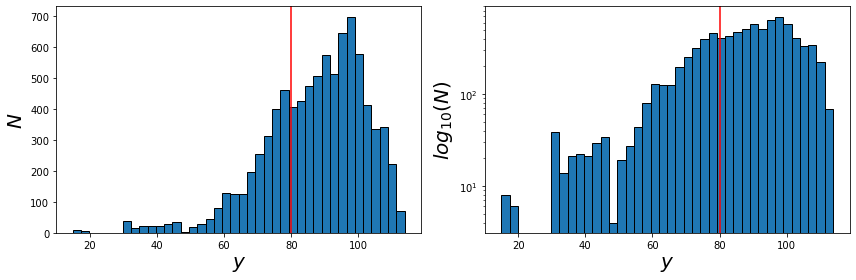

In [29]:
nbins   = 40
x0_list = [2, 8, 10, 31.5, 80]
for x0 in x0_list:
    print('#'*100, 'x0: '+str(x0), '#'*100, sep='\n')
    esurf_m1.plot_interp(x0_line=x0, log_scale=True)
    esurf_m1.plot_hist(x0, nbins=nbins)